In [1]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline
from keras.preprocessing.image import array_to_img
import copy
import seaborn as sns
import time
import cv2 as cv
import pickle
from PIL import Image
from tensorflow.keras.layers import AveragePooling2D
import shutil
import pandas as pd
from numpy.random import default_rng
from useful_functions import *
from tensorflow.keras.layers import AveragePooling2D
import cv2
from PIL import Image  
import PIL

In [2]:
with open('./tick_list.pkl', 'rb') as f:
    tick_list = pickle.load(f)

In [3]:
G = 500 # number of grid points
p = 240
q = 360
N0 = 1000 # number of images to compute the GPA matrix
area_thres = 0.02 * p * q
print(area_thres)

test_data = pd.read_csv('./label-0718.csv')
test_data = test_data.iloc[:, 1:8]
test_data.head()

10368.0


,FileName,Sub,Label,Left_Y,Left_X,Right_Y,Right_X
0,00000004014000000_200000.jpg,None,1,187.5,139.0,403.5,363.5
1,00000004014000000_200025.jpg,None,1,167.0,152.5,408.0,399.0
2,00000004014000000_200050.jpg,None,1,134.5,166.5,401.0,438.0
3,00000004014000000_200075.jpg,None,1,102.0,172.5,408.0,482.5
4,00000004014000000_200100.jpg,None,1,55.0,178.0,396.0,530.0


In [4]:
test_data['Area'] = np.nan
# change the coordinates from str to int
test_data.loc[test_data.Label >= 0, ['Left_Y', 'Left_X', 'Right_Y', 'Right_X']] = test_data.loc[test_data.Label >= 0, ['Left_Y', 'Left_X', 'Right_Y', 'Right_X']].astype('float').astype('int')
test_data['GPA_IOU'] = np.nan
test_data['GPA_label'] = np.nan
test_data['GPA_time'] = np.nan

# test_data.loc[test_data.Label >= 0, ['Left_Y', 'Left_X', 'Right_Y', 'Right_X']] = test_data.loc[test_data.Label >= 0, ['Left_Y', 'Left_X', 'Right_Y', 'Right_X']] / 2

test_data.loc[test_data.Label >= 0, 'Area'] = (test_data.loc[test_data.Label >= 0, 'Right_Y'] - test_data.loc[test_data.Label >= 0, 'Left_Y']) \
    * (test_data.loc[test_data.Label >= 0, 'Right_X'] - test_data.loc[test_data.Label >= 0, 'Left_X'])

test_data.loc[(test_data.Area.notnull()) & (test_data.Area < area_thres), ['Label', 'Left_Y', 'Left_X', 'Right_Y', 'Right_X']] \
    = [-1, None, None, None, None]


# tmp_data = test_data.loc[(test_data.Area.notnull()), ]
# test_data.loc[(test_data.Area.notnull()) & (tmp_data.Area <= 60000) & (tmp_data["Right_Y"] >= 950), ['Label', 'Left_Y', 'Left_X', 'Right_Y', 'Right_X']] = [-1, None, None, None, None]
# test_data.loc[(test_data.Area.notnull()) & (tmp_data.Area <= 60000) & (tmp_data["Right_X"] >= 530), ['Label', 'Left_Y', 'Left_X', 'Right_Y', 'Right_X']] = [-1, None, None, None, None]

test_data['Inter_label'] = test_data.Label
test_data.loc[test_data.Label == 1, "Inter_label"] = 0

test_data = test_data.sort_values(by=["FileName", "Area"],
                                  ascending=[True, False])  # by指定按哪列排序。ascending表示是否升序

In [5]:
test_data.head(5)

,FileName,Sub,Label,Left_Y,Left_X,Right_Y,Right_X,Area,GPA_IOU,GPA_label,GPA_time,Inter_label
0,00000004014000000_200000.jpg,None,1,187,139,403,363,48384,NaN,NaN,NaN,0
1,00000004014000000_200025.jpg,None,1,167,152,408,399,59527,NaN,NaN,NaN,0
2,00000004014000000_200050.jpg,None,1,134,166,401,438,72624,NaN,NaN,NaN,0
3,00000004014000000_200075.jpg,None,1,102,172,408,482,94860,NaN,NaN,NaN,0
4,00000004014000000_200100.jpg,None,1,55,178,396,530,120032,NaN,NaN,NaN,0


In [7]:
a = test_data.FileName.unique()
a.shape

(3622,)

In [6]:
test_data

,FileName,Sub,Label,Left_Y,Left_X,Right_Y,Right_X,Area,GPA_IOU,GPA_label,GPA_time,Inter_label
0,00000004014000000_200000.jpg,None,1,187,139,403,363,48384,NaN,NaN,NaN,0
1,00000004014000000_200025.jpg,None,1,167,152,408,399,59527,NaN,NaN,NaN,0
2,00000004014000000_200050.jpg,None,1,134,166,401,438,72624,NaN,NaN,NaN,0
3,00000004014000000_200075.jpg,None,1,102,172,408,482,94860,NaN,NaN,NaN,0
4,00000004014000000_200100.jpg,None,1,55,178,396,530,120032,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3757,00000004014000000_290425.jpg,None,-1,None,None,None,None,NaN,NaN,NaN,NaN,-1
3758,00000004014000000_290450.jpg,None,-1,None,None,None,None,NaN,NaN,NaN,NaN,-1
3759,00000004014000000_290475.jpg,None,-1,None,None,None,None,NaN,NaN,NaN,NaN,-1
3760,00000004014000000_290500.jpg,None,-1,None,None,None,None,NaN,NaN,NaN,NaN,-1


In [6]:
# for file in test_data.FileName.unique():
#     tmp_data = test_data.loc[test_data["FileName"] == file, ]
#     if len(tmp_data) == 1:
#         test_data.loc[test_data["FileName"] == file, "Sub"] = "None"
#     elif len(tmp_data) == 2:
#         test_data.loc[test_data["FileName"] == file, "Sub"] = [1, 2] 

In [7]:
test_size = test_data.shape[0]
print(test_size)
test_data.index = range(test_size)

3762


In [8]:
with open('./GPA_matrix.pkl', 'rb') as f:
    GPA_tensor = pickle.load(f)
GPA_tensor /= tf.reduce_max(GPA_tensor) # tf.reduce_max(GPA_tensor, axis=0)
GPA_tensor.shape

TensorShape([500, 540, 960])

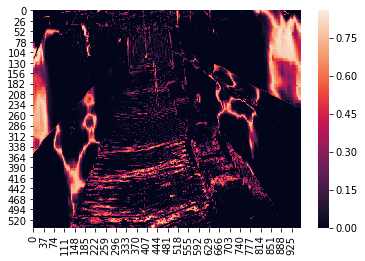

In [9]:
sns.heatmap(GPA_tensor[0])

In [10]:
path = '/database/datasets/MineSafe/whole/'
test_size = test_data.shape[0]
shape = (540, 960)
tick_tensor = tf.concat([tf.ones([1, p, q]) * tick for tick in tick_list], axis=0)
print(tick_tensor.shape)
alpha = np.log(p * q) / np.log(N0)
bandwidth, bandwidth_star = compute_optimal_bandwidths(N0, alpha)

(500, 540, 960)
Optimal bandwidth from Rule of Thumb: 0.013175117431337695
Optimal bandwidth* from GPA estimation: 0.0008679185966476918


In [11]:
def compute_IOU(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [12]:
blur_len = 33
avg_blur_2d = AveragePooling2D(pool_size=(blur_len, blur_len), strides=1, padding='same')
thres = 0.06
blur_thres = 0.42

In [25]:
# DEBUG = True
DEBUG = False
SAVE = False
# SAVE = True

for i in range(test_size):
# for i in range(4):
# for i in [3469]:
# for i in test_data.index:
    print(f"+++++++++++++ {i} +++++++++++++++")
    
    sub = test_data.loc[i, "Sub"]
    area = test_data.loc[i, "Area"]
    print("area:", area)
    
    if sub == 2 or sub == '2':
        print("Sub=2: Already process this image. Moving on to the next one.")
        continue
    
    image_name = test_data.loc[i, 'FileName'] # Obtain the ith image's name
    image_path = path + image_name # whole path for the image
    test_img = load_and_preprocess_image(image_path, shape) # load the image TensorShape([540, 960])
    print(image_name)
    
    if SAVE:
        im1 = Image.open(image_path)  
        # save a image using extension 
        im1 = im1.save(image_name)
        print(image_name)
        continue
    
    boxA1 = produce_coordinate(test_data, i)
    label1 = test_data.loc[i, "Label"]
    if sub != "None" and sub is not None:
        boxA2 = produce_coordinate(test_data, i+1)
        label2 = test_data.loc[i+1, "Label"]
    
    if DEBUG:
        print(boxA1)
        if boxA1[0] != "None" and boxA1[0] is not None:
            x, y, x1, y1 = boxA1
            print((y1 - y) * (x1 - x) / (p * q))
#             show_img_one_channel(test_img, True)
            plot_sub_img(test_img, boxA1)
            print(test_data.loc[i, 'Area'])
        else:
            print(test_data.loc[i, 'Area'])
            show_img_one_channel(test_img, True)
            
    # GPA 估计
    t1 = time.time()
    Omega2_star = K_tf(tick_tensor - test_img, bandwidth_star)
    Omega1_star = Omega2_star * GPA_tensor
    Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
    Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
    GPA_density = Omega1_star / Omega2_star
    t2 = time.time()
    test_data.loc[i, "GPA_time"] = t2 - t1
    print(f"Computing GPA Density Time: {t2 - t1}")
#     if DEBUG:
# #         print(tf.reduce_max(GPA_density))
# #         sns.heatmap(GPA_density, cmap="YlOrRd")
#         sns.heatmap(GPA_density, cmap="Greys")
#         plt.xticks([])
#         plt.yticks([])
#         plt.axis('off')
#         plt.show()
    
    # Object Detection
    clear_tensor = tf.reshape(GPA_density, (1, p, q, 1))
    clear_tensor = tf.cast(GPA_density <= thres, tf.float32) * GPA_density + tf.cast(GPA_density > thres, tf.float32)
    clear_tensor = tf.reshape(clear_tensor, (1, p, q, 1))
    if DEBUG:
        print("==========Clear Tensor==========")
        sns.heatmap(tf.squeeze(clear_tensor), cmap="Greys")
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
    
    # blur
    blur_tensor = avg_blur_2d(clear_tensor)
    blur_tensor = tf.squeeze(blur_tensor)
#     if DEBUG:
#         sns.heatmap(blur_tensor, cmap="Greys")
#         plt.xticks([])
#         plt.yticks([])
#         plt.axis('off')
#         plt.show()
    
    # remove background
    rm_tensor = tf.cast(blur_tensor < blur_thres, dtype=tf.float32)
    if DEBUG:
        sns.heatmap(rm_tensor, cmap="Greys")  #YlGnBu
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
    
    
    img = tf.cast(rm_tensor, tf.uint8)
    img = img.numpy()
#     if DEBUG:
#         sns.heatmap(img, cmap="YlGnBu") #YlGnBu
#         plt.xticks([])
#         plt.yticks([])
#         plt.axis('off')
#         plt.show()
    
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
    
    stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
    stats = stats[1:, ] # 去掉背景
    if DEBUG:
        print(stats)
    
    stats = stats[stats[:, 4] > 4000] # 去掉过小的连通块
    stats = stats[stats[:, 5] > 7500] # 去掉过小的连通块
    if DEBUG:
        print("=========print stats 4&5 > some area=========")
        print(stats)
        print()
    
    
    # Discarding bounding boxes that are too small
    stats = stats[(stats[:, 2] >= 60) & (stats[:, 3] >= 60), ]
    if DEBUG:
        print("=========print >=60&60=========")
        print(stats)
        print()
    
    
    stats = stats[(stats[:, 1] + stats[:, 3] <= 539) | (stats[:, 4] >= 70000) | (stats[:, 5] >= 150000), ]
    if DEBUG:
        print("=========Print Stats11:=========")
        print(stats)
        print()
    
    stats = stats[(stats[:, 1] <= 210) | (stats[:, 4] >= 70000), ]
    if DEBUG:
        print("=========Print Stats22:=========")
        print(stats)
        print()
    
    stats = stats[(stats[:, 0] + stats[:, 2] <= 959) | (stats[:, 4] >= 70000) | (stats[:, 5] >= 150000), ] 
    if DEBUG:
        print("=========Print Stats33:=========")
        print(stats)
        print()
    
    stats = stats[(stats[:, 0] <= 700) | (stats[:, 4] >= 70000), ]
    if DEBUG:
        print("=========Print Stats44:=========")
        print(stats)
        print()
        
    if len(stats) == 0: # 如果没有符合要求的联通区域
        test_data.loc[i, 'GPA_label'] = -1
        print(f"Real Label:{test_data.loc[i, 'Label']}")
        print(f"GPA label:{test_data.loc[i, 'GPA_label']}")
        current_label_acc = np.mean(test_data.loc[0:i, "Inter_label"] == test_data.loc[0:i, "GPA_label"])
        print(f"---Current Label Prediction Accuracy:{current_label_acc}")
        continue
    
    test_data.loc[i, "GPA_label"] = 0

    # 计算IOU
    tmp = stats[0, :]
    x = tmp[1]; y = tmp[0]; width = tmp[3]; height = tmp[2]
    boxB1 = [x, y, x+width, y+height]
    if boxA1[0] != "None" and boxA1[0] is not None:
        GPA_IOU = compute_IOU(boxA1, boxB1)
        test_data.loc[i, 'GPA_IOU'] = GPA_IOU
    small_img = test_img[x:(x+width), y:(y+height)] 
    
    if DEBUG:
        print(f"boxA1:{boxA1}")
        print(f"boxB1:{boxB1}")
        plot_sub_img(test_img, boxA1, boxB1)

    print(f"Real Label:{test_data.loc[i, 'Label']}")
    print(f"GPA label:{test_data.loc[i, 'GPA_label']}")
    print(f"GPA IOU:{test_data.loc[i, 'GPA_IOU']}")
    
    if sub != "None" and sub is not None:
        try:
            tmp = stats[1, :] # 最大的连通图
            x = tmp[1]; y = tmp[0]; width = tmp[3]; height = tmp[2]
            boxB2 = [x, y, x+width, y+height]
            test_data.loc[i+1, "GPA_label"] = 0
#             small_img2 = test_img[x:(x+width), y:(y+height)]
            GPA_IOU2 = compute_IOU(boxA2, boxB2)
            test_data.loc[i+1, 'GPA_IOU'] = GPA_IOU2
        except:
            test_data.loc[i+1, "GPA_label"] = -1
        if DEBUG:
            print("boxA2:", boxA2)
            print("boxB2:", boxB2)
            plot_sub_img(test_img, boxA2, boxB2)
        
        print(f"Real Label:{test_data.loc[i+1, 'Label']}")
        print(f"GPA label:{test_data.loc[i+1, 'GPA_label']}")
        print(f"GPA IOU:{test_data.loc[i+1, 'GPA_IOU']}")
    
    
    current_label_acc = np.mean(test_data.loc[0:i, "Inter_label"] == test_data.loc[0:i, "GPA_label"])
    print(f"---Current Label Prediction Accuracy:{current_label_acc}")
    print(f"---Current IOU mean:{np.nanmean(test_data.GPA_IOU)}")
    print(f"---Current IOU median:{np.nanmedian(test_data.GPA_IOU)}")
    boxA1 = None
    boxA2 = None
    boxB1 = None
    boxB2 = None
#     test_data.to_csv('./test_data_GPA_0703.csv')

+++++++++++++ 0 +++++++++++++++
area: 48384
00000004014000000_200000.jpg
Computing GPA Density Time: 0.01786351203918457
Real Label:1
GPA label:0.0
GPA IOU:0.7686985400954819
---Current Label Prediction Accuracy:1.0
---Current IOU mean:0.87759014976608
---Current IOU median:0.9100265402989853


### Show Example Image and Detect Image

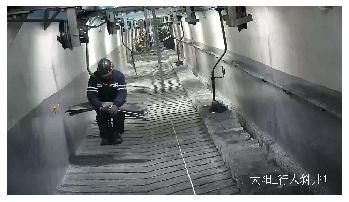

In [17]:
# image = tf.io.read_file(image_path)
# image = tf.image.decode_image(image, dtype=tf.float32)
# image = tf.image.resize(image, shape)
# # image = tf.reduce_mean(image, axis=2)
# plt.imshow(image)
# plt.xticks([])
# plt.yticks([])
# plt.axis('off')
# plt.show()

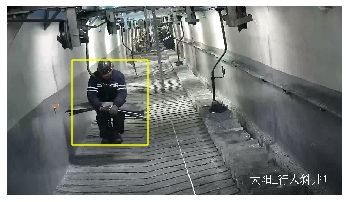

In [24]:
# show_img_3_channels(image, False)

# x1, y1, x2, y2 = boxB1
# col = 'yellow'
# plt.vlines(y1, ymin=x1, ymax=x2, color=col)
# plt.vlines(y2, ymin=x1, ymax=x2, color=col)
# plt.hlines(x1, xmin=y1, xmax=y2, color=col)
# plt.hlines(x2, xmin=y1, xmax=y2, color=col)

# plt.show()

In [56]:
test_data['CD_IOU'] = np.nan
test_data['CD_label'] = np.nan
test_data['CD_time'] = np.nan
test_data.head()

,FileName,Sub,Label,Left_Y,Left_X,Right_Y,Right_X,Area,GPA_IOU,GPA_label,GPA_time,Inter_label,CD_IOU,CD_label,CD_time
0,00000004014000000_200000.jpg,None,1,187,139,403,363,48384,0.768699,0.0,0.018309,0,NaN,NaN,NaN
1,00000004014000000_200025.jpg,None,1,167,152,408,399,59527,0.912145,0.0,0.018331,0,NaN,NaN,NaN
2,00000004014000000_200050.jpg,None,1,134,166,401,438,72624,0.907908,0.0,0.017586,0,NaN,NaN,NaN
3,00000004014000000_200075.jpg,None,1,102,172,408,482,94860,0.921609,0.0,0.018096,0,NaN,NaN,NaN
4,00000004014000000_200100.jpg,None,1,55,178,396,530,120032,0.938870,-1.0,0.018047,0,NaN,NaN,NaN


In [1]:
DEBUG = False

for i in range(test_size):
# for i in range(362, 364):
# for i in [0]:
# for i in test_data.index:
    print(f"+++++++++++++ {i} +++++++++++++++")
    
    sub = test_data.loc[i, "Sub"]
    area = test_data.loc[i, "Area"]
    print("area:", area)
    
    if sub == 2 or sub == '2':
        print("Sub=2: Already process this image. Moving on to the next one.")
        continue
    
    image_name = test_data.loc[i, 'FileName'] # Obtain the ith image's name
    image_path = path + image_name # whole path for the image
    test_img = load_and_preprocess_image(image_path, shape) # load the image TensorShape([540, 960])
    
#     im1 = Image.open(image_path)  
#     # save a image using extension 
#     im1 = im1.save(image_name)
#     print(image_name)
#     continue
    
    boxA1 = produce_coordinate(test_data, i)
    label1 = test_data.loc[i, "Label"]
    if sub != "None" and sub is not None:
        boxA2 = produce_coordinate(test_data, i+1)
        label2 = test_data.loc[i+1, "Label"]
    
    if DEBUG:
        print(boxA1)
        if boxA1[0] != "None" and boxA1[0] is not None:
            plot_sub_img(test_img, boxA1)
            print(test_data.loc[i, 'Area'])
        else:
            print(test_data.loc[i, 'Area'])
            show_img_one_channel(test_img, True)
            
    # CD 估计
    CD_density = np.load("./CD_density/" + image_name[:(-4)] + '.npy', allow_pickle=True)
    
    # Object Detection
    clear_tensor = tf.reshape(CD_density, (1, p, q, 1))
    clear_tensor = tf.cast(CD_density <= thres, tf.float32) * CD_density + tf.cast(CD_density > thres, tf.float32)
    clear_tensor = tf.reshape(clear_tensor, (1, p, q, 1))
    if DEBUG:
        print("==========Clear Tensor==========")
        sns.heatmap(tf.squeeze(clear_tensor), cmap="Greys")
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
    
    # blur
    blur_tensor = avg_blur_2d(clear_tensor)
    blur_tensor = tf.squeeze(blur_tensor)
#     if DEBUG:
#         sns.heatmap(blur_tensor, cmap="Greys")
#         plt.xticks([])
#         plt.yticks([])
#         plt.axis('off')
#         plt.show()
    
    # remove background
    rm_tensor = tf.cast(blur_tensor < blur_thres, dtype=tf.float32)
    if DEBUG:
        sns.heatmap(rm_tensor, cmap="Greys")  #YlGnBu
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
    
    
    img = tf.cast(rm_tensor, tf.uint8)
    img = img.numpy()
#     if DEBUG:
#         sns.heatmap(img, cmap="YlGnBu") #YlGnBu
#         plt.xticks([])
#         plt.yticks([])
#         plt.axis('off')
#         plt.show()
    
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
    
    stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
    stats = stats[1:, ] # 去掉背景
    if DEBUG:
        print(stats)
    
    stats = stats[stats[:, 4] > 4000] # 去掉过小的连通块
    stats = stats[stats[:, 5] > 7500] # 去掉过小的连通块
    if DEBUG:
        print("=========print stats 4&5 > some area=========")
        print(stats)
        print()
    
    
    # Discarding bounding boxes that are too small
    stats = stats[(stats[:, 2] >= 60) & (stats[:, 3] >= 60), ]
    if DEBUG:
        print("=========print >=60&60=========")
        print(stats)
        print()
    
    
    stats = stats[(stats[:, 1] + stats[:, 3] <= 539) | (stats[:, 4] >= 70000) | (stats[:, 5] >= 150000), ]
    if DEBUG:
        print("=========Print Stats11:=========")
        print(stats)
        print()
    
    stats = stats[(stats[:, 1] <= 210) | (stats[:, 4] >= 70000), ]
    if DEBUG:
        print("=========Print Stats22:=========")
        print(stats)
        print()
    
    stats = stats[(stats[:, 0] + stats[:, 2] <= 959) | (stats[:, 4] >= 70000) | (stats[:, 5] >= 150000), ] 
    if DEBUG:
        print("=========Print Stats33:=========")
        print(stats)
        print()
    
    stats = stats[(stats[:, 0] <= 700) | (stats[:, 4] >= 70000), ]
    if DEBUG:
        print("=========Print Stats44:=========")
        print(stats)
        print()
        
    if len(stats) == 0: # 如果没有符合要求的联通区域
        test_data.loc[i, 'CD_label'] = -1
        print(f"Real Label:{test_data.loc[i, 'Label']}")
        print(f"CD label:{test_data.loc[i, 'CD_label']}")
        current_label_acc = np.mean(test_data.loc[0:i, "Inter_label"] == test_data.loc[0:i, "CD_label"])
        print(f"---Current Label Prediction Accuracy:{current_label_acc}")
        continue
    
    test_data.loc[i, "CD_label"] = 0

    # 计算IOU
    tmp = stats[0, :]
    x = tmp[1]; y = tmp[0]; width = tmp[3]; height = tmp[2]
    boxB1 = [x, y, x+width, y+height]
    if boxA1[0] != "None" and boxA1[0] is not None:
        CD_IOU = compute_IOU(boxA1, boxB1)
        test_data.loc[i, 'CD_IOU'] = CD_IOU
    small_img = test_img[x:(x+width), y:(y+height)] 
    
    if DEBUG:
        print(f"boxA1:{boxA1}")
        print(f"boxB1:{boxB1}")
        plot_sub_img(test_img, boxA1, boxB1)

    print(f"Real Label:{test_data.loc[i, 'Label']}")
    print(f"CD label:{test_data.loc[i, 'CD_label']}")
    print(f"CD IOU:{test_data.loc[i, 'CD_IOU']}")
    
    if sub != "None" and sub is not None:
        try:
            tmp = stats[1, :] # 最大的连通图
            x = tmp[1]; y = tmp[0]; width = tmp[3]; height = tmp[2]
            boxB2 = [x, y, x+width, y+height]
            test_data.loc[i+1, "CD_label"] = 0
#             small_img2 = test_img[x:(x+width), y:(y+height)]
            CD_IOU2 = compute_IOU(boxA2, boxB2)
            test_data.loc[i+1, 'CD_IOU'] = CD_IOU2
        except:
            test_data.loc[i+1, "CD_label"] = -1
        if DEBUG:
            print("boxA2:", boxA2)
            print("boxB2:", boxB2)
            plot_sub_img(test_img, boxA2, boxB2)
        
        print(f"Real Label:{test_data.loc[i+1, 'Label']}")
        print(f"CD label:{test_data.loc[i+1, 'CD_label']}")
        print(f"CD IOU:{test_data.loc[i+1, 'CD_IOU']}")
    
    
    current_label_acc = np.mean(test_data.loc[0:i, "Inter_label"] == test_data.loc[0:i, "CD_label"])
    print(f"---Current Label Prediction Accuracy:{current_label_acc}")
    print(f"---Current IOU mean:{np.nanmean(test_data.CD_IOU)}")
    print(f"---Current IOU median:{np.nanmedian(test_data.CD_IOU)}")
    boxA1 = None
    boxA2 = None
    boxB1 = None
    boxB2 = None
#     test_data.to_csv('./test_data_GPA_0703.csv')

In [59]:
test_data.to_csv('./label_GPA+CD-0718-2.csv')

In [ ]:
# y, x, h, w = [692, 390, 78, 80]
# small_img = test_img[x:(x+w), y:(y+h)]
# plt.imshow(small_img)
# plt.show()

In [ ]:
# y, x, h, w = 477,    98,    65,    97
# small_img = test_img[x:(x+w), y:(y+h)]
# plt.imshow(small_img)
# plt.show()

In [ ]:
current_label_acc = np.mean(test_data.loc[:, "Inter_label"] == test_data.loc[:, "GPA_label"])

print(f"---Current Label Prediction Accuracy:{current_label_acc}")
print(f"---Current IOU mean:{np.nanmean(test_data.GPA_IOU)}")
print(f"---Current IOU median:{np.nanmedian(test_data.GPA_IOU)}")